# Graph visualization using NetworkX

This notebook demonstrates the use of the TrustGraph triple store API to fetch information from the knowledge graph. This information is then visualized using the networkX graph visualisation library.  This notebook was executed against a running TrustGraph loaded with the space shuttle challenger report from NASA located here:

https://ntrs.nasa.gov/citations/19860015255

In [1]:
!pip install networkx
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import trustgraph.api as tg

In [3]:
cli = tg.Api()

In [4]:
# Utility function, given a label works backward to find the URI of the graph node associated with that label
def get_entity(label):

    resp = cli.triples_query(
        p = "http://www.w3.org/2000/01/rdf-schema#label",
        o = label,
        limit = 1
    )

    # Return first row answer
    for row in resp:
        return row.s

    # Or raise exception
    raise RuntimeError("Couldn't resolve entity")

In [5]:
# Given an entity URI, find the label
def get_label(ent):

    if ent == "http://www.w3.org/2000/01/rdf-schema#label": return "label"
    if ent == "https://schema.org/subjectOf": return "subject of"
    if ent.startswith("https://trustgraph.ai/doc/"): return "source document"
    if ent == "http://www.w3.org/2004/02/skos/core#definition": return "definition"
    if ent == "https://schema.org/keywords": return "keyword"
    if ent == "https://schema.org/description": return "keyword"
    if ent == "http://www.w3.org/1999/02/22-rdf-syntax-ns#type": return "type"
    if ent == "https://schema.org/copyrightNotice": return "(c) notice"
    if ent == "https://schema.org/copyrightHolder": return "(c) held"
    if ent == "https://schema.org/copyrightYear": return "(c) year"

    if not ent.startswith("http"): return ent

    resp = cli.triples_query(
        s = ent,
        p = "http://www.w3.org/2000/01/rdf-schema#label",
        limit = 1
    )

    for row in resp:
        return row.o
        
    # If no label, just dump the entity, the URI can be its label
    return ent

In [6]:
# Given a graph node specified by URI, find related edges which start at that node
def get_related_edges(s, limit=20, follows=1):

    resp = cli.triples_query(
        s = s,
        limit = limit
    )

    res = [
        [s, row.p, row.o]
        for row in resp
    ]

    if follows > 1:
        seeds = [ r[2] for r in res ]
        for se in seeds:
            if se.startswith("http"):
                res.extend(get_related_edges(se, limit, follows - 1))

    return res

In [7]:
# Get some useful starting seeds
shuttle = get_entity("Space Shuttle")
booster = get_entity("Solid Rocket Booster")
tank = get_entity("external fuel tank")
thruster = get_entity("thruster")
#explosion = get_entity("explosion")
#oring = get_entity("o-ring")

In [8]:
# Follow edges start at the seeds above to build a collection of statements
edges = []
edges.extend(get_related_edges(shuttle))
edges.extend(get_related_edges(booster))
edges.extend(get_related_edges(tank))
edges.extend(get_related_edges(thruster))

In [9]:
edges

[['http://trustgraph.ai/e/space-shuttle',
  'http://trustgraph.ai/e/became-the-focus-of',
  'http://trustgraph.ai/e/nasa%27s-near-term-future'],
 ['http://trustgraph.ai/e/space-shuttle',
  'http://trustgraph.ai/e/certified-for',
  'http://trustgraph.ai/e/operational-flights'],
 ['http://trustgraph.ai/e/space-shuttle',
  'http://trustgraph.ai/e/composed-of',
  'http://trustgraph.ai/e/orbiter%2C-external-fuel-tank%2C-and-two-solid-rocket-boosters'],
 ['http://trustgraph.ai/e/space-shuttle',
  'http://trustgraph.ai/e/composed-of',
  'http://trustgraph.ai/e/orbiter%2C-external-fuel-tank%2C-two-solid-rocket-boosters'],
 ['http://trustgraph.ai/e/space-shuttle',
  'http://trustgraph.ai/e/deliver-payload-to',
  'http://trustgraph.ai/e/easterly-low-earth-orbit'],
 ['http://trustgraph.ai/e/space-shuttle',
  'http://trustgraph.ai/e/deliver-payload-to',
  'http://trustgraph.ai/e/polar-orbit'],
 ['http://trustgraph.ai/e/space-shuttle',
  'http://trustgraph.ai/e/designed-to-deliver',
  '32,000 pound

# Visualization

To make networkX happy this information needs to be modeled in a different way.  This information gets converted into various forms which use numeric IDs instead of strings.

In [10]:
# Produces a list of entities which are sources and objects.  This list does not contain predicates
ents = list(set([e[0] for e in edges] + [e[2] for e in edges]))

# URI to ID mapping in both directions
id2label = { ix: ent for ix, ent in enumerate(ents) }
label2id = { ent: ix for ix, ent in enumerate(ents) }

# ID to human-readable label for nodes
id2name = { ix: get_label(ent) for ix, ent in enumerate(ents) }

In [11]:
# Edge list, list of (subject, object) pairs
network_e = [(label2id[e[0]], label2id[e[2]]) for e in edges]

In [12]:
# Mapping from edge to edge label
edge_labels = {
    (label2id[e[0]], label2id[e[2]]): get_label(e[1])
    for e in edges
}

In [13]:
# Create a directed graph using NetworkX
network = nx.DiGraph()

# Add edges
network.add_edges_from(network_e)

# Visualize the directed graph using a spring layout - this computes positions for all nodes
pos = nx.spring_layout(network)

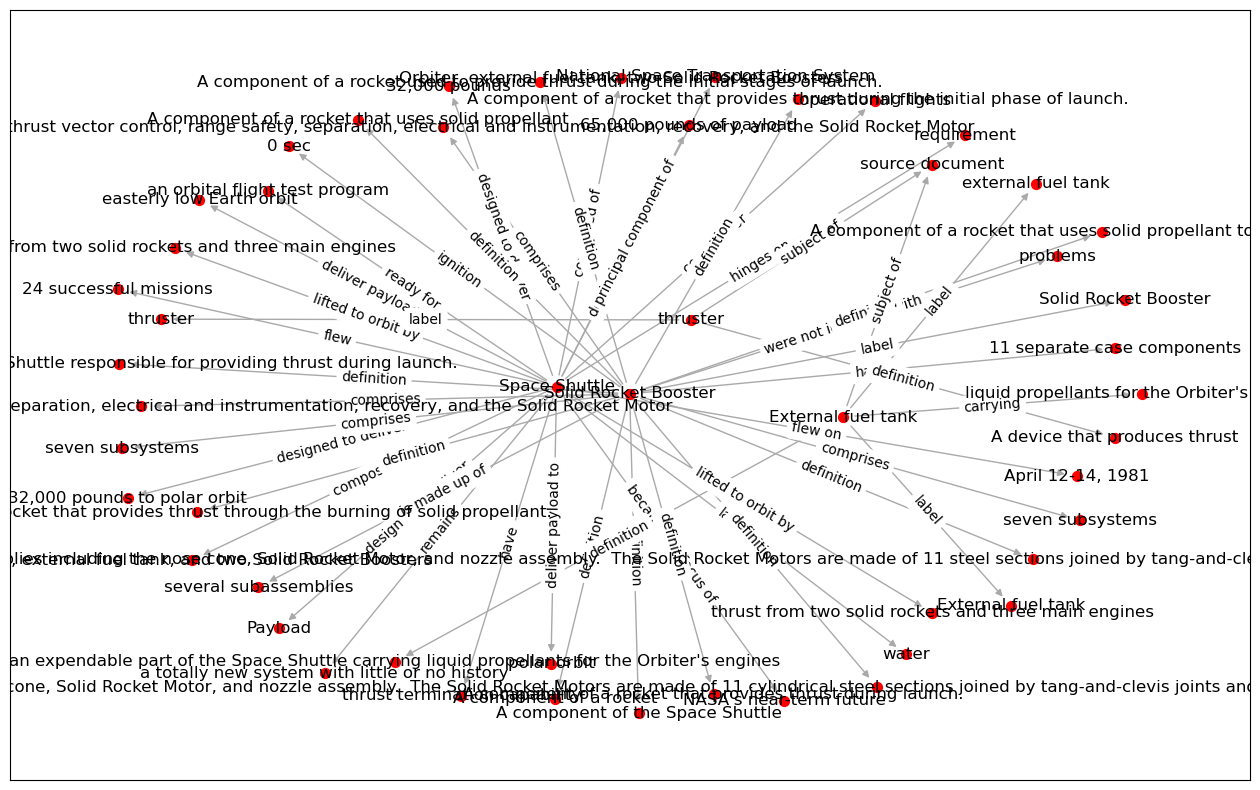

In [14]:
# Get drawing.  Nice big image frame
plt.figure(figsize=(16,10))

# Draw nodes, edges, labels on nodes and labels on edges
nx.draw_networkx_nodes(network, pos, node_shape='o', node_color='red', node_size=50)
nx.draw_networkx_edges(network, pos, edge_color='darkgray')
nx.draw_networkx_labels(network, pos, labels=id2name)
nx.draw_networkx_edge_labels(network, pos, edge_labels=edge_labels)

# Show the pic
plt.show()